In [ ]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.9 MB/s eta 0:00:00


In [3]:
# Cell 1: Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

In [ ]:
# Cell 2: Load preprocessed training data

data_path = "./Data/training_data.csv" 
df = pd.read_csv(data_path)
df["date"] = pd.to_datetime(df["date"])

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

Shape: (5832737, 11)
Columns: ['item_id', 'date', 'demand', 'lag_1', 'lag_7', 'lag_28', 'wday', 'month', 'year', 'is_weekend', 'is_holiday']
       item_id       date  demand  lag_1  lag_7  lag_28  wday  month  year  \
0  FOODS_1_001 2011-02-26       2    4.0    1.0     3.0     1      2  2011   
1  FOODS_1_001 2011-02-27       2    2.0    2.0     0.0     2      2  2011   
2  FOODS_1_001 2011-02-28       0    2.0    0.0     0.0     3      2  2011   
3  FOODS_1_001 2011-03-01       2    0.0    2.0     1.0     4      3  2011   
4  FOODS_1_001 2011-03-02       1    2.0    2.0     4.0     5      3  2011   

   is_weekend  is_holiday  
0           1           0  
1           1           0  
2           0           0  
3           0           0  
4           0           0  


In [6]:
# Cell 3: Train/Test split by last 28 days

last_date = df["date"].max()
test_start = last_date - pd.Timedelta(days=27)

print("Last date in data:", last_date)
print("Test start date:", test_start)

train_mask = df["date"] < test_start
test_mask = df["date"] >= test_start

train_df = df[train_mask].copy()
test_df = df[test_mask].copy()

print("\nTrain date range:", train_df["date"].min(), "→", train_df["date"].max())
print("Test date range :", test_df["date"].min(), "→", test_df["date"].max())
print("Train size:", len(train_df), "rows")
print("Test size :", len(test_df), "rows")
print("Unique test days:", test_df["date"].nunique())

Last date in data: 2016-05-22 00:00:00
Test start date: 2016-04-25 00:00:00

Train date range: 2011-02-26 00:00:00 → 2016-04-24 00:00:00
Test date range : 2016-04-25 00:00:00 → 2016-05-22 00:00:00
Train size: 5747365 rows
Test size : 85372 rows
Unique test days: 28


In [ ]:
# Cell 4: Define feature sets and target

target_col = "demand"

# Model A: lag
features_A = ["lag_1", "lag_7", "lag_28"]

# Model B: lag + calendar 
features_B = [
    "lag_1", "lag_7", "lag_28",
    "wday", "month", "year",
    "is_weekend", "is_holiday"
]

print("Model A features:", features_A)
print("Model B features:", features_B)

print("\nMissing values in train_df:")
print(train_df[features_B + [target_col]].isna().sum())
print("\nMissing values in test_df:")
print(test_df[features_B + [target_col]].isna().sum())

Model A features: ['lag_1', 'lag_7', 'lag_28']
Model B features: ['lag_1', 'lag_7', 'lag_28', 'wday', 'month', 'year', 'is_weekend', 'is_holiday']

Missing values in train_df:
lag_1         0
lag_7         0
lag_28        0
wday          0
month         0
year          0
is_weekend    0
is_holiday    0
demand        0
dtype: int64

Missing values in test_df:
lag_1         0
lag_7         0
lag_28        0
wday          0
month         0
year          0
is_weekend    0
is_holiday    0
demand        0
dtype: int64


In [8]:
# Cell 5: Build X, y for both models

X_train_A = train_df[features_A].values
X_test_A = test_df[features_A].values

X_train_B = train_df[features_B].values
X_test_B = test_df[features_B].values

y_train = train_df[target_col].values
y_test = test_df[target_col].values

print("X_train_A shape:", X_train_A.shape)
print("X_test_A shape :", X_test_A.shape)
print("X_train_B shape:", X_train_B.shape)
print("X_test_B shape :", X_test_B.shape)
print("y_train shape  :", y_train.shape)
print("y_test shape   :", y_test.shape)

X_train_A shape: (5747365, 3)
X_test_A shape : (85372, 3)
X_train_B shape: (5747365, 8)
X_test_B shape : (85372, 8)
y_train shape  : (5747365,)
y_test shape   : (85372,)


In [9]:
# Cell 6: Train Model A (lag-only XGBoost)

model_A = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

print("Training Model A (lag-only)...")
model_A.fit(X_train_A, y_train)

# 在最后 28 天上做预测
y_pred_A = model_A.predict(X_test_A)

rmse_A = mean_squared_error(y_test, y_pred_A, squared=False)
print(f"\nModel A RMSE (lag-only, last 28 days): {rmse_A:.4f}")

Training Model A (lag-only)...

Model A RMSE (lag-only, last 28 days): 2.2237


/opt/anaconda3/envs/demand_forecast_cpu/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
# Cell 7: Train Model B (lag + calendar XGBoost)

model_B = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

print("Training Model B (lag + calendar)...")
model_B.fit(X_train_B, y_train)

y_pred_B = model_B.predict(X_test_B)

rmse_B = mean_squared_error(y_test, y_pred_B, squared=False)
print(f"\nModel B RMSE (lag + calendar, last 28 days): {rmse_B:.4f}")

Training Model B (lag + calendar)...

Model B RMSE (lag + calendar, last 28 days): 2.2122


/opt/anaconda3/envs/demand_forecast_cpu/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
# Cell 8: Attach predictions to test_df for further analysis

results_df = test_df.copy()
results_df["pred_A"] = y_pred_A
results_df["pred_B"] = y_pred_B

print(results_df.head())

          item_id       date  demand  lag_1  lag_7  lag_28  wday  month  year  \
1885  FOODS_1_001 2016-04-25       2    0.0    4.0     2.0     3      4  2016   
1886  FOODS_1_001 2016-04-26       0    2.0    1.0     1.0     4      4  2016   
1887  FOODS_1_001 2016-04-27       0    0.0    1.0     1.0     5      4  2016   
1888  FOODS_1_001 2016-04-28       0    0.0    0.0     0.0     6      4  2016   
1889  FOODS_1_001 2016-04-29       0    0.0    1.0     4.0     7      4  2016   

      is_weekend  is_holiday    pred_A    pred_B  
1885           0           0  1.614753  1.445603  
1886           0           0  1.259548  1.155700  
1887           0           0  0.779394  0.724053  
1888           0           0  0.141848  0.257130  
1889           0           0  1.311887  1.316841  


In [12]:
# Cell 9: Compare RMSE of Model A vs Model B

rmse_summary = pd.DataFrame({
    "Model": ["A (lag-only)", "B (lag + calendar)"],
    "RMSE_last_28_days": [rmse_A, rmse_B]
})

print(rmse_summary)

                Model  RMSE_last_28_days
0        A (lag-only)           2.223741
1  B (lag + calendar)           2.212241


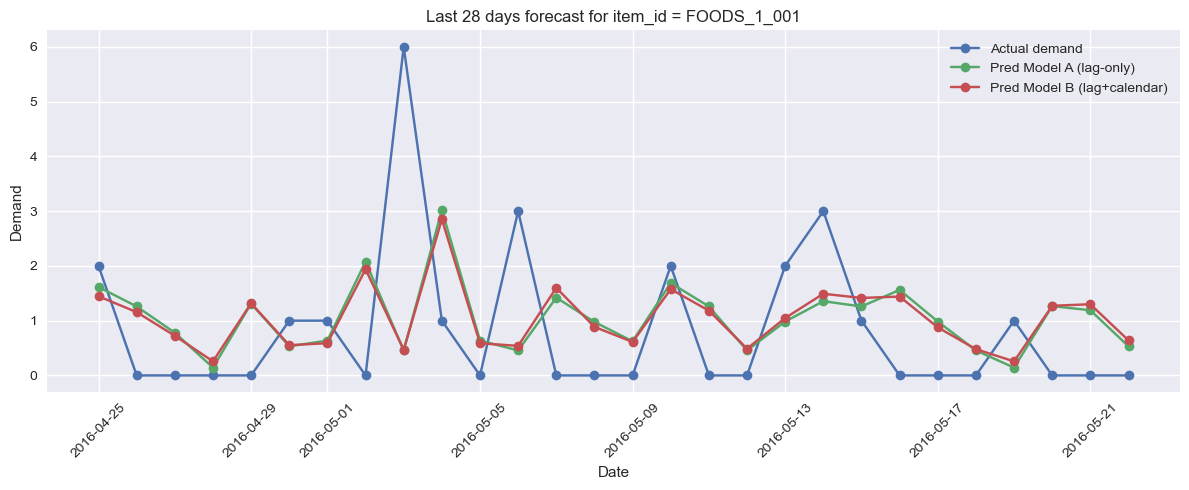

In [ ]:
# Cell 10: Plot actual vs predicted for one example item (optional but recommended)

example_item = results_df["item_id"].iloc[0]

plot_df = results_df[results_df["item_id"] == example_item].sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(plot_df["date"], plot_df["demand"], marker="o", label="Actual demand")
plt.plot(plot_df["date"], plot_df["pred_A"], marker="o", label="Pred Model A (lag-only)")
plt.plot(plot_df["date"], plot_df["pred_B"], marker="o", label="Pred Model B (lag+calendar)")

plt.title(f"Last 28 days forecast for item_id = {example_item}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()